In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
jax.config.update("jax_enable_x64", True)
import diffrax

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### Question 1: how does the glycolysis model reproduce other datasets?

In [2]:


def get_interpolations(time_points,glycolysis_data):
    coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                                fill_forward_nans_at_end=True)
    EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)                               
    coeffs_ICATP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICATP']),
                                                fill_forward_nans_at_end=True)
    ICATP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICATP)     

    coeffs_ICADP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICADP']),
                                                fill_forward_nans_at_end=True)
    ICADP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICADP)     
    coeffs_ICAMP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICAMP']),
                                                fill_forward_nans_at_end=True)
    ICAMP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICAMP)  
    interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    "ICATP":ICATP_interpolation_cubic,
                    "ICADP":ICADP_interpolation_cubic,
                    "ICAMP":ICAMP_interpolation_cubic}
    return interpolated_mets


def get_initial_conditions(y0_dict,glycolysis_data):
    initials=glycolysis_data.iloc[0,:].dropna().to_dict()

    for key in y0_dict.keys():
        try:
            y0_dict[key]=initials[key]
        except:
            continue
    return y0_dict




In [3]:
GP2_data['ECglucose']

NameError: name 'GP2_data' is not defined

In [13]:
from models.manual_implementations.glycolysis.glycolysis_model import *

GP1_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
GP2_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF2_timeseries_format.csv",index_col=0).T

#as a test case

# GP2_data['ECglucose']=GP2_data['ECglucose'].mean()

GP3_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF3_timeseries_format.csv",index_col=0).T
time_points1=[float(i) for i in GP1_data.index.to_list()]
time_points2=[float(i) for i in GP2_data.index.to_list()]
time_points3=[float(i) for i in GP3_data.index.to_list()]


y0_dict={'ICG1P':0.064568,
         "ICT6P":0.093705,
         "ICtreh":63.312040,
         'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
          "ICPEP":1.171415,
          "ICPYR":0.152195,
          "ICACE":0.04,
          "ICETOH":10.0,
          "ICNADH":0.0106,
          "ICNAD":1.5794}




interpolated_mets1=get_interpolations(time_points1,GP1_data)
interpolated_mets2=get_interpolations(time_points2,GP2_data)
interpolated_mets3=get_interpolations(time_points3,GP3_data)


metabolite_names=list(y0_dict.keys())


y0_1dict=get_initial_conditions(y0_dict,GP1_data).copy()
# print(y0_1dict)
y0_2dict=get_initial_conditions(y0_dict,GP2_data).copy()
# print(y0_2dict)
y0_3dict=get_initial_conditions(y0_dict,GP3_data).copy()

y0_1=jnp.array(list(y0_1dict.values()))
y0_2=jnp.array(list(y0_2dict.values()))
y0_3=jnp.array(list(y0_3dict.values()))

glycolyse1=jax.jit(NeuralODE(glycolysis(interpolated_mets1,metabolite_names)))
glycolyse2=jax.jit(NeuralODE(glycolysis(interpolated_mets2,metabolite_names)))
glycolyse3=jax.jit(NeuralODE(glycolysis(interpolated_mets3,metabolite_names)))





ts1=jnp.linspace(0,time_points1[-1],1000)
ts2=jnp.linspace(0,time_points2[-1],1000)
ts3=jnp.linspace(0,time_points3[-1],1000)

parameters=pd.read_csv("results/EXP3_Glycolysis/1508_parameters_glucosepulse1.csv",index_col=0)
initial_parameters=parameters['Initialized_Parameters'].to_dict()
trained_parameters=parameters['Trained_Parameters'].to_dict()



ys_trained_parameters1=glycolyse1(ts1,y0_1,trained_parameters)
print("A")
ys_trained_parameters2=glycolyse2(ts2,y0_2,trained_parameters)
print("B")
ys_trained_parameters3=glycolyse3(ts3,y0_3,trained_parameters)
print("C")
ys_initialparameters1=glycolyse1(ts1,y0_1,initial_parameters)
print("D")
ys_initialparameters2=glycolyse2(ts2,y0_2,initial_parameters)
print("E")
ys_initialparameters3=glycolyse3(ts3,y0_3,initial_parameters)

ys_trained_parameters1=pd.DataFrame(ys_trained_parameters1,index=ts1,columns=metabolite_names)
ys_trained_parameters2=pd.DataFrame(ys_trained_parameters2,index=ts2,columns=metabolite_names)
ys_trained_parameters3=pd.DataFrame(ys_trained_parameters3,index=ts3,columns=metabolite_names)


ys_initialparameters1=pd.DataFrame(ys_initialparameters1,index=ts1,columns=metabolite_names)
ys_initialparameters2=pd.DataFrame(ys_initialparameters2,index=ts2,columns=metabolite_names)
ys_initialparameters3=pd.DataFrame(ys_initialparameters3,index=ts3,columns=metabolite_names)

A
B
C
D
E


In [318]:
np.argmax(y0_1-y0_2)


Array(2, dtype=int64)

Text(0.03, 0.21, 'Dataset 3 (unseen)')

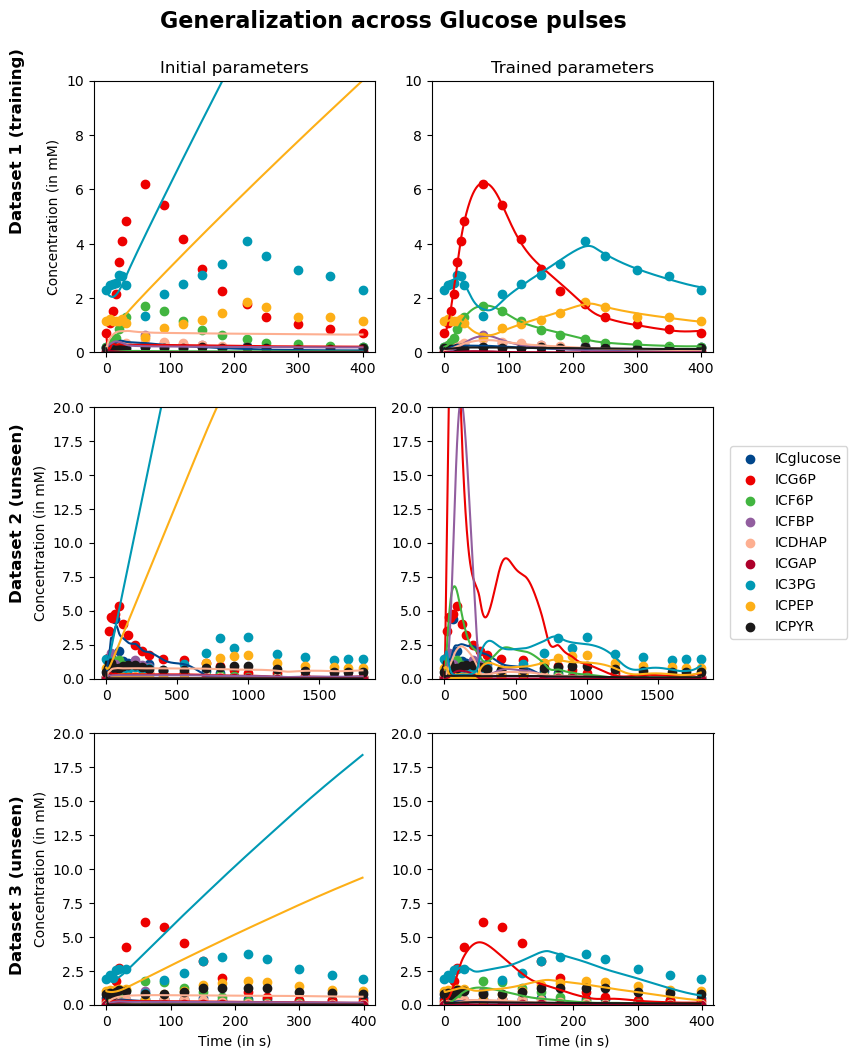

In [14]:


fig,axs=plt.subplots(3,2,figsize=(8,12))



lancet_colors = {
    'ICglucose': '#00468B',    # Lancet Blue
    'ICG6P': '#ED0000',    # Lancet Red
    'ICF6P': '#42B540',   # Lancet Green
    'ICFBP': '#925E9F',# Lancet Purple
    'ICDHAP': '#FDAF91',    # Lancet Orange
    'ICGAP': '#AD002A',    # Lancet Pink
    'IC3PG': '#0099B4',    # Lancet Cyan
    'ICPEP': '#FDAF17',   # Lancet Yellow
    'ICPYR': '#1B1919'}    # Lancet Teal}

met_names=["ICglucose","ICG6P","ICF6P","ICFBP","ICDHAP","ICGAP","IC3PG","IC2PG","ICPEP","ICPYR"]
for met in met_names:
    try:
      axs[0,0].scatter(time_points1,GP1_data[met],label=met,c=lancet_colors[met])
      axs[0,0].plot(ts1,ys_initialparameters1[met],c=lancet_colors[met])
      axs[0,1].scatter(time_points1,GP1_data[met],label=met,c=lancet_colors[met])
      axs[0,1].plot(ts1,ys_trained_parameters1[met],c=lancet_colors[met])
      mets.append(met)
    except:
       continue
    

for met in met_names:
    try:
      axs[1,0].scatter(time_points2,GP2_data[met],label=met,c=lancet_colors[met])
      axs[1,0].plot(ts2,ys_initialparameters2[met],c=lancet_colors[met])
      axs[1,1].scatter(time_points2,GP2_data[met],label=met,c=lancet_colors[met])
      axs[1,1].plot(ts2,ys_trained_parameters2[met],c=lancet_colors[met])
    except:
       continue
    


for met in met_names:
    try:
      axs[2,0].scatter(time_points3,GP3_data[met],label=met,c=lancet_colors[met])
      axs[2,0].plot(ts3,ys_initialparameters3[met],c=lancet_colors[met])
      axs[2,1].scatter(time_points3,GP3_data[met],label=met,c=lancet_colors[met])
      axs[2,1].plot(ts3,ys_trained_parameters3[met],c=lancet_colors[met])
    except:
       continue
axs[0,0].set_title("Initial parameters")
axs[0,1].set_title("Trained parameters")
axs[0,1].legend(loc="center right",bbox_to_anchor=(1.5,-0.7))
fig.suptitle("Generalization across Glucose pulses",va="bottom",fontsize=16,y=0.92,fontweight="bold")
# plt.yscale("log")

axs[0,0].set_ylim(0,10)
axs[0,1].set_ylim(0,10)
axs[1,0].set_ylim(0,20)
axs[1,1].set_ylim(0,20)
axs[2,0].set_ylim(0,20)
axs[2,1].set_ylim(0,20)


axs[2,0].set_xlabel("Time (in s)")
axs[2,1].set_xlabel("Time (in s)")
axs[0,0].set_ylabel("Concentration (in mM)")
axs[1,0].set_ylabel("Concentration (in mM)")
axs[2,0].set_ylabel("Concentration (in mM)")

fig.text(0.03, 0.83, "Dataset 1 (training)", ha='center', va='center', fontsize=12,fontweight="bold", rotation=90)
fig.text(0.03, 0.52, "Dataset 2 (unseen)", ha='center', va='center', fontsize=12,fontweight="bold", rotation=90)
fig.text(0.03, 0.21, "Dataset 3 (unseen)", ha='center', va='center', fontsize=12, fontweight="bold",rotation=90)
# fig.savefig("figures/figures_glycolysis/test_unseen_glucosepulses.svg",bbox_inches="tight")
# fig.savefig("figures/figures_glycolysis/test_unseen_glucosepulses.png",bbox_inches="tight")

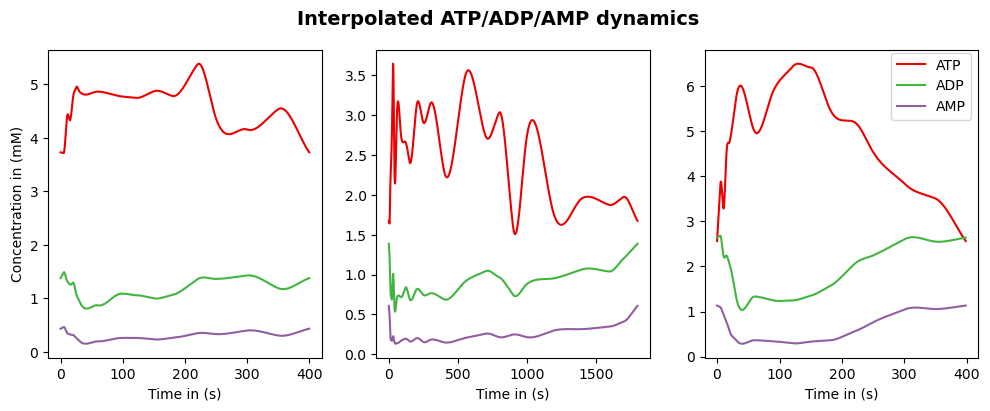

In [250]:
#look at all interpolations
    # 'ICglucose': '#00468B',    # Lancet Blue
    # 'ICG6P': '#ED0000',    # Lancet Red
    # 'ICF6P': '#42B540',   # Lancet Green
    # 'ICFBP': '#925E9F',# Lancet Purple
    # 'ICDHAP': '#FDAF91',    # Lancet Orange


# plt.plot(ts1,interpolated_mets1['ECglucose'].evaluate(ts1),c="#00468B")
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].plot(ts1,interpolated_mets1['ICATP'].evaluate(ts1),c="#ED0000",label="ATP")
axs[0].plot(ts1,interpolated_mets1['ICADP'].evaluate(ts1),c="#42B540",label="ADP")
axs[0].plot(ts1,interpolated_mets1['ICAMP'].evaluate(ts1),c="#925E9F",label="AMP")



# plt.plot(ts2,interpolated_mets2['ECglucose'].evaluate(ts2),c="#00468B")
axs[1].plot(ts2,interpolated_mets2['ICATP'].evaluate(ts2),c="#ED0000")
axs[1].plot(ts2,interpolated_mets2['ICADP'].evaluate(ts2),c="#42B540")
axs[1].plot(ts2,interpolated_mets2['ICAMP'].evaluate(ts2),c="#925E9F")

# plt.plot(ts3,interpolated_mets3['ECglucose'].evaluate(ts3),c="#00468B")
axs[2].plot(ts3,interpolated_mets3['ICATP'].evaluate(ts3),c="#ED0000")
axs[2].plot(ts3,interpolated_mets3['ICADP'].evaluate(ts3),c="#42B540")
axs[2].plot(ts3,interpolated_mets3['ICAMP'].evaluate(ts3),c="#925E9F")
fig.legend(loc="upper right",bbox_to_anchor=(0.9,0.89))
fig.suptitle("Interpolated ATP/ADP/AMP dynamics",fontsize=14,fontweight="bold")
axs[0].set_ylabel("Concentration in (mM)")
axs[0].set_xlabel("Time in (s)")
axs[1].set_xlabel("Time in (s)")
axs[2].set_xlabel("Time in (s)")
fig.savefig("figures/figures_glycolysis/ATP_ADP_AMP_interpolated_dynamics.svg")
fig.savefig("figures/figures_glycolysis/ATP_ADP_AMP_interpolated_dynamics.png")

In [281]:
def mse(GP_data,simulated_data):
    metabolites=np.intersect1d(GP1_data.columns,simulated_data.columns)
    trues=[]
    for met in metabolites:
        true=(GP_data[met].values-simulated_data[met].values)**2
        trues.append(true)
    trues=np.array(trues)
    trues=trues[~np.isnan(trues)]
    return np.mean(trues)


A
B
C
D
E


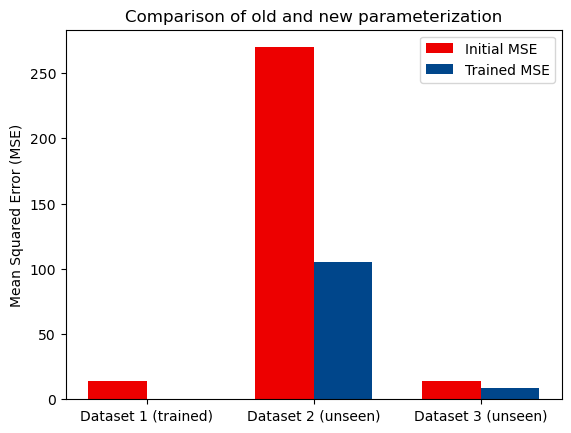

In [292]:
ys_trained_parameters1=glycolyse1(time_points1,y0_1,trained_parameters)
print("A")
ys_trained_parameters2=glycolyse2(time_points2,y0_2,trained_parameters)
print("B")
ys_trained_parameters3=glycolyse3(time_points3,y0_3,trained_parameters)
print("C")
ys_initialparameters1=glycolyse1(time_points1,y0_1,initial_parameters)
print("D")
ys_initialparameters2=glycolyse2(time_points2,y0_2,initial_parameters)
print("E")
ys_initialparameters3=glycolyse3(time_points3,y0_3,initial_parameters)

ys_trained_parameters1=pd.DataFrame(ys_trained_parameters1,index=time_points1,columns=metabolite_names)
ys_trained_parameters2=pd.DataFrame(ys_trained_parameters2,index=time_points2,columns=metabolite_names)
ys_trained_parameters3=pd.DataFrame(ys_trained_parameters3,index=time_points3,columns=metabolite_names)


ys_initialparameters1=pd.DataFrame(ys_initialparameters1,index=time_points1,columns=metabolite_names)
ys_initialparameters2=pd.DataFrame(ys_initialparameters2,index=time_points2,columns=metabolite_names)
ys_initialparameters3=pd.DataFrame(ys_initialparameters3,index=time_points3,columns=metabolite_names)

mse1_trained=mse(GP1_data,ys_trained_parameters1)
mse1_initial=mse(GP1_data,ys_initialparameters1)

mse2_trained=mse(GP2_data,ys_trained_parameters2)
mse2_initial=mse(GP2_data,ys_initialparameters2)

mse3_trained=mse(GP3_data,ys_trained_parameters3)
mse3_initial=mse(GP3_data,ys_initialparameters3)



categories = ['Dataset 1 (trained)', 'Dataset 2 (unseen)', 'Dataset 3 (unseen)']
initial_mse = [mse1_initial, mse2_initial, mse3_initial]
trained_mse = [mse1_trained, mse2_trained, mse3_trained]

# Set bar width and positions
bar_width = 0.35
x = np.arange(len(categories))

# Create bar plot
fig, ax = plt.subplots()

bars1 = ax.bar(x - bar_width/2, initial_mse, bar_width,color="#ED0000FF", label='Initial MSE')
bars2 = ax.bar(x + bar_width/2, trained_mse, bar_width,color="#00468BFF", label='Trained MSE')

# Add labels and title

ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Comparison of old and new parameterization')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
fig.savefig("figures/figures_glycolysis/MSE_for datasets.svg")
fig.savefig("figures/figures_glycolysis/MSE_for datasets.png")

### Below we have the model parameters for the same dataset. 
The question is how the fitted parameters generalize to other datasets

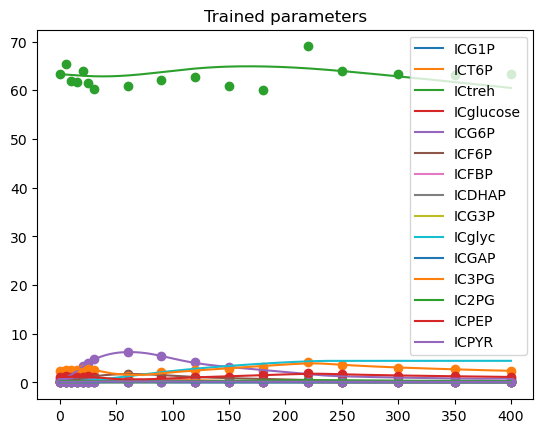

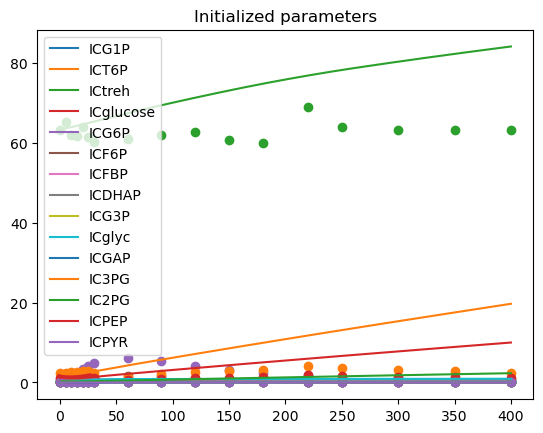

In [19]:

#initial model


#now load parameter set from training
parameters=pd.read_csv("results/EXP3_Glycolysis/1508_parameters_glucosepulse1.csv",index_col=0)

initial_parameters=parameters['Initialized_Parameters'].to_dict()
trained_parameters=parameters['Trained_Parameters'].to_dict()

ys_trained_parameters=glycolyse(ts,y0,trained_parameters)
ys_df=pd.DataFrame(ys_trained_parameters,index=ts,columns=metabolite_names)
for met in metabolite_names:
    try:
      
      plt.scatter(time_points,glycolysis_data[met])
      plt.plot(list(ys_df.index),ys_df[met],label=met)
    except:
       continue
plt.title("Trained parameters")
plt.legend()
plt.show()

ys_initialparameters=glycolyse(ts,y0,initial_parameters)
ys_df=pd.DataFrame(ys_initialparameters,index=ts,columns=metabolite_names)
for met in metabolite_names:
    try:
      
      plt.scatter(time_points,glycolysis_data[met])
      plt.plot(list(ys_df.index),ys_df[met],label=met)
    except:
       continue
plt.title("Initialized parameters")
plt.legend()
plt.show()




In [27]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF2_timeseries_format.csv",index_col=0).T
time_points=[float(i) for i in glycolysis_data.index.to_list()]
# time_points=[int(i) for i in glycolysis_data.index.to_list()]

coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)
EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)
                               
coeffs_ICATP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICATP']),
                                             fill_forward_nans_at_end=True)
ICATP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICATP)     

coeffs_ICADP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICADP']),
                                             fill_forward_nans_at_end=True)
ICADP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICADP)     

coeffs_ICAMP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICAMP']),
                                             fill_forward_nans_at_end=True)
ICAMP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICAMP)  


y0_dict={'ICG1P':0.064568,
         "ICT6P":0.093705,
         "ICtreh":63.312040,
         'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
          "ICPEP":1.171415,
          "ICPYR":0.152195,
          "ICACE":0.04,
          "ICETOH":10.0,
          "ICNADH":0.0106,
          "ICNAD":1.5794}


initials=glycolysis_data.iloc[0,:].dropna().to_dict()

for key in y0_dict.keys():
    try:
        y0_dict[key]=initials[key]
    except:
        continue



y0_dict['ICglyc']=100
interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    "ICATP":ICATP_interpolation_cubic,
                    "ICADP":ICADP_interpolation_cubic,
                    "ICAMP":ICAMP_interpolation_cubic}

y0=jnp.array(list(y0_dict.values()))
metabolite_names=list(y0_dict.keys())

glycolyse=glycolysis(interpolated_mets,metabolite_names)
metabolite_names=glycolyse.met_names
glycolyse=jax.jit(NeuralODE(glycolysis(interpolated_mets,metabolite_names)))
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,time_points[-1],1000)

In [ ]:
## look at the inteprolations for each

### Can this model represent steady state input of glucose and perhaps ATP/ADP/AMP?

Compare steady state to canela's data

In [15]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF3_timeseries_format.csv",index_col=0).T
time_points=[float(i) for i in glycolysis_data.index.to_list()]
# time_points=[int(i) for i in glycolysis_data.index.to_list()]


glycolysis_data['ECglucose']=0.2

glycolysis_data['ICATP']=np.mean(glycolysis_data['ICATP'])
glycolysis_data['ICADP']=np.mean(glycolysis_data['ICADP'])
glycolysis_data['ICAMP']=np.mean(glycolysis_data['ICAMP'])

coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)
EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)
                               
coeffs_ICATP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICATP']),
                                             fill_forward_nans_at_end=True)
ICATP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICATP)     

coeffs_ICADP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICADP']),
                                             fill_forward_nans_at_end=True)
ICADP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICADP)     

coeffs_ICAMP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICAMP']),
                                             fill_forward_nans_at_end=True)
ICAMP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICAMP)  


y0_dict={'ICG1P':0.064568,
         "ICT6P":0.093705,
         "ICtreh":63.312040,
         'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
          "ICPEP":1.171415,
          "ICPYR":0.152195,
          "ICACE":0.04,
          "ICETOH":10.0,
          "ICNADH":0.0106,
          "ICNAD":1.5794}


initials=glycolysis_data.iloc[0,:].dropna().to_dict()

for key in y0_dict.keys():
    try:
        y0_dict[key]=initials[key]
    except:
        continue

interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    "ICATP":ICATP_interpolation_cubic,
                    "ICADP":ICADP_interpolation_cubic,
                    "ICAMP":ICAMP_interpolation_cubic}

y0=jnp.array(list(y0_dict.values()))
metabolite_names=list(y0_dict.keys())

glycolyse=glycolysis(interpolated_mets,metabolite_names)
metabolite_names=glycolyse.met_names
glycolyse=jax.jit(NeuralODE(glycolysis(interpolated_mets,metabolite_names)))
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,time_points[-1],1000)


In [86]:
trained_parameters.keys()

dict_keys(['f_ETOH_e', 'f_GLYCEROL_e', 'f_NTH1', 'flux_ugp', 'km_sinkACE', 'km_sinkF6P', 'km_sinkG6P', 'km_sinkGAP', 'km_sinkP3G', 'km_sinkPEP', 'km_sinkPYR', 'p_ADH_ExprsCor', 'p_ADH_KeqADH', 'p_ADH_KiADHACE', 'p_ADH_KiADHETOH', 'p_ADH_KiADHNAD', 'p_ADH_KiADHNADH', 'p_ADH_KmADHACE', 'p_ADH_KmADHETOH', 'p_ADH_KmADHNAD', 'p_ADH_KmADHNADH', 'p_ADH_VmADH', 'p_ENO1_K2pg', 'p_ENO1_Keq', 'p_ENO1_Kpep', 'p_ENO1_Vm', 'p_FBA1_Kdhap', 'p_FBA1_Keq', 'p_FBA1_Kf16bp', 'p_FBA1_Kglyceral3p', 'p_FBA1_Vmax', 'p_GAPDH_Vmax', 'p_GLT_KmGLTGLCi', 'p_GLT_KmGLTGLCo', 'p_GLT_VmGLT', 'p_GPD1_Kadp', 'p_GPD1_Katp', 'p_GPD1_Kdhap', 'p_GPD1_Keq', 'p_GPD1_Kf16bp', 'p_GPD1_Kglyc3p', 'p_GPD1_Knad', 'p_GPD1_Knadh', 'p_GPD1_Vmax', 'p_GlycerolTransport', 'p_HOR2_Kglyc3p', 'p_HOR2_Kpi', 'p_HOR2_Vmax', 'p_HXK1_Kadp', 'p_HXK1_Katp', 'p_HXK1_Keq', 'p_HXK1_Kg6p', 'p_HXK1_Kglc', 'p_HXK1_Kt6p', 'p_HXK_Vmax', 'p_NTH1_Ktre', 'p_NTH1_Vmax', 'p_NTH1_kcat', 'p_PDC1_Kpi', 'p_PDC1_Kpyr', 'p_PDC1_Vmax', 'p_PDC1_hill', 'p_PFK_Camp', 'p

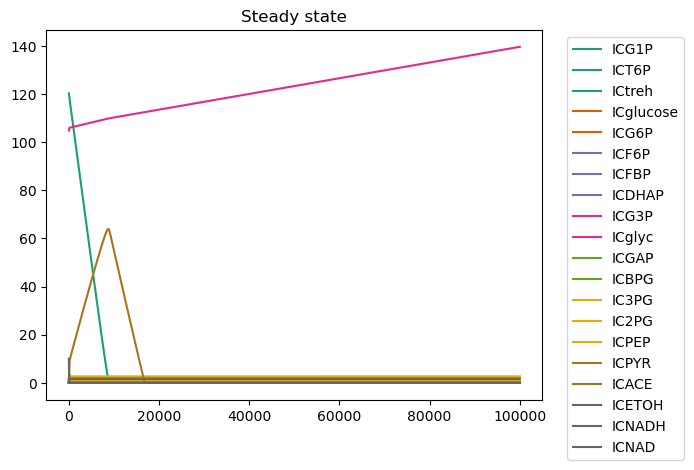

'ICACE'

In [59]:
import matplotlib.cm as cm
colors = cm.Dark2(np.linspace(0, 1, len(metabolite_names)))

ts=jnp.linspace(0,100000,10000)
ys_trained_parameters=glycolyse(ts,y0,trained_parameters)




ys_df=pd.DataFrame(ys_trained_parameters,index=ts,columns=metabolite_names)




for color, met in zip(colors, metabolite_names):
    try:
        plt.plot(list(ys_df.index), ys_df[met], label=met, color=color)
    except:
        continue
plt.title("Steady state")
plt.legend(loc="upper right",bbox_to_anchor=(1.3,1))
# plt.ylim(0,1)
# plt.yscale("log")
plt.show()

# ts=jnp.linspace(0,400,1000)
# new_params=trained_parameters
# new_params['p_ADH_VmADH']=trained_parameters['p_ADH_VmADH']*5
# ys_trained_parameters=glycolyse(ts,y0,trained_parameters)
# ys_df=pd.DataFrame(ys_trained_parameters,index=ts,columns=metabolite_names)
# for met in metabolite_names:
#     try:
      
#       plt.scatter(time_points,glycolysis_data[met])
#       plt.plot(list(ys_df.index),ys_df[met],label=met)
#     except:
#        continue
# plt.title("Trained parameters")
# plt.legend()
# plt.ylim(0,10)
# plt.show()

# ys_df['ICPYR']

np.unique(np.where(ys_df>40)[1])

metabolite_names[16]

#ICtreh, ICglyc, icACE

In [181]:
parameters=pd.read_csv("results/EXP3_Glycolysis/1508_parameters_glucosepulse1.csv",index_col=0)

initial_parameters=parameters['Initialized_Parameters'].to_dict()
trained_parameters=parameters['Trained_Parameters'].to_dict()

steady_state_data=pd.read_csv('datasets/VanHeerden_Glucose_Pulse/canelas_SS_data.csv',index_col=0)

#we only parameterized on growth rate =0.1, so we only use this data
steady_state_D01=steady_state_data[['Data_3']]


mets_in_data=np.intersect1d(steady_state_D01.index,metabolite_names)
steady_state_D01_values=steady_state_D01.loc[mets_in_data,:]


dictionary_ss=steady_state_D01_values['Data_3'].to_dict()


new_y0=y0_dict.copy()
for key in dictionary_ss.keys():
    new_y0[key]=dictionary_ss[key]



ts=np.linspace(0,10,100)
ECgluc=np.ones(len(ts))
ATP=np.ones(len(ts))
ADP=np.ones(len(ts))
AMP=np.ones(len(ts))
ECgluc[:]=0.18

ATP[:]=3.2965
ADP[:]=0.8925
AMP[:]=0.025

coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(ts),ys=ECgluc,
                                            fill_forward_nans_at_end=True)
EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(ts),coeffs=coeffs_ECglucose)                               
coeffs_ICATP=diffrax.backward_hermite_coefficients(ts=jnp.array(ts),ys=ATP,
                                            fill_forward_nans_at_end=True)
ICATP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(ts),coeffs=coeffs_ICATP)     

coeffs_ICADP=diffrax.backward_hermite_coefficients(ts=jnp.array(ts),ys=ADP,
                                            fill_forward_nans_at_end=True)
ICADP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(ts),coeffs=coeffs_ICADP)     
coeffs_ICAMP=diffrax.backward_hermite_coefficients(ts=jnp.array(ts),ys=AMP,
                                            fill_forward_nans_at_end=True)
ICAMP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(ts),coeffs=coeffs_ICAMP)  

interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    "ICATP":ICATP_interpolation_cubic,
                    "ICADP":ICADP_interpolation_cubic,
                    "ICAMP":ICAMP_interpolation_cubic}

y0=jnp.array(list(new_y0.values()))
metabolite_names=list(new_y0.keys())

glycolyse=glycolysis(interpolated_mets,metabolite_names)
metabolite_names=glycolyse.met_names
glycolyse=jax.jit(NeuralODE(glycolysis(interpolated_mets,metabolite_names)))



# glycolyse=glycolysis(interpolated_mets,metabolite_names)

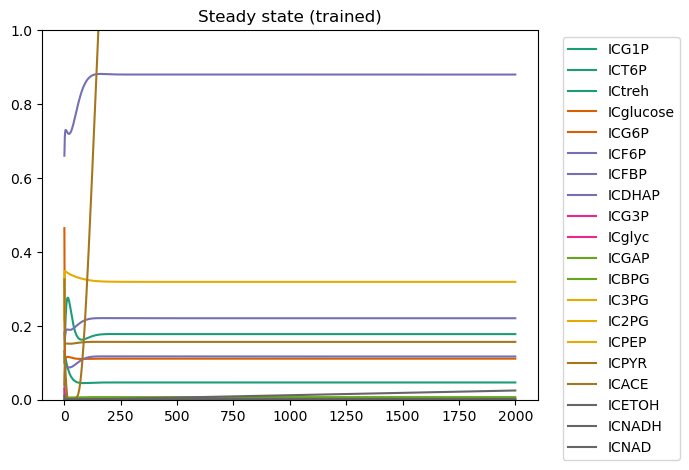

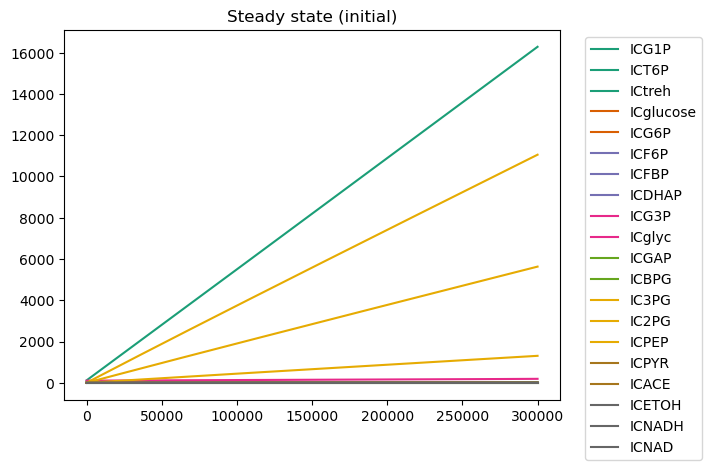

In [235]:
ts=jnp.linspace(0,2000,1000)
ys_trained_parameters=glycolyse(ts,y0,trained_parameters)
ys_df=pd.DataFrame(ys_trained_parameters,index=ts,columns=metabolite_names)


for color, met in zip(colors, metabolite_names):
    try:
        plt.plot(list(ys_df.index), ys_df[met], label=met, color=color)
    except:
        continue
plt.title("Steady state (trained)")
plt.ylim(0,1)
plt.legend(loc="upper right",bbox_to_anchor=(1.3,1))
plt.show()

ts=jnp.linspace(0,300000,1000)
ys_initial_parameters=glycolyse(ts,y0,initial_parameters)
ys_initial_parameters=pd.DataFrame(ys_initial_parameters,index=ts,columns=metabolite_names)


for color, met in zip(colors, metabolite_names):
    try:
        plt.plot(list(ys_initial_parameters.index), ys_initial_parameters[met], label=met, color=color)
    except:
        continue
plt.title("Steady state (initial)")
# plt.ylim(0,10)
plt.legend(loc="upper right",bbox_to_anchor=(1.3,1))
plt.show()




In [236]:
y0_after_simulation=ys_df.iloc[-1,:].to_dict()
y0_after_simulation_initial=ys_initial_parameters.iloc[-1,:].to_dict()

eval_dict={**y0_after_simulation,**trained_parameters}
eval_dict['ICPHOS']=10
eval_dict['ICATP']=3.2965
eval_dict['ICADP']=0.8925
eval_dict['ICAMP']=0.025
eval_dict['ECglucose']=0.18



ss_trained_parameters={"v_HXK":v_HXK(eval_dict),"v_PGI":v_PGI(eval_dict),
                    "v_PFK":v_PFK(eval_dict),"v_TPI":v_TPI1(eval_dict),
                    "v_GAPDH":v_GAPDH(eval_dict),"v_ENO":v_ENO(eval_dict),
                    "v_G3PDH":v_G3PDH(eval_dict),"v_PGK":v_PGK(eval_dict),'v_FBA':v_ALD(eval_dict),"v_PGM":v_PGM(eval_dict),
                    "v_PYK1":v_PYK1(eval_dict),"v_GLT":v_GLT(eval_dict),"v_PDC":v_PDC(eval_dict),"v_ADH":v_ADH(eval_dict),
                    "vsinkG6P":v_sinkG6P(eval_dict),"vsinkF6P":v_sinkF6P(eval_dict),
                    "vsinkGAP":v_sinkGAP(eval_dict),"vsink3PGA":v_sinkF6P(eval_dict),
                    "vsinkPEP":vsinkPEP(eval_dict),"vsinkPYR":vsinkPYR(eval_dict),"vsinkACE":vsinkACE(eval_dict)}


eval_dict={**y0_after_simulation_initial,**initial_parameters}
eval_dict['ICPHOS']=10
eval_dict['ICATP']=3.2965
eval_dict['ICADP']=0.8925
eval_dict['ICAMP']=0.025
eval_dict['ECglucose']=0.18
ss_initial_parameters={"v_HXK":v_HXK(eval_dict),"v_PGI":v_PGI(eval_dict),
                    "v_PFK":v_PFK(eval_dict),"v_TPI":v_TPI1(eval_dict),
                    "v_GAPDH":v_GAPDH(eval_dict),"v_ENO":v_ENO(eval_dict),
                    "v_G3PDH":v_G3PDH(eval_dict),"v_PGK":v_PGK(eval_dict),'v_FBA':v_ALD(eval_dict),"v_PGM":v_PGM(eval_dict),
                    "v_PYK1":v_PYK1(eval_dict),"v_GLT":v_GLT(eval_dict),"v_PDC":v_PDC(eval_dict),"v_ADH":v_ADH(eval_dict),
                    "vsinkG6P":v_sinkG6P(eval_dict),"vsinkF6P":v_sinkF6P(eval_dict),
                    "vsinkGAP":v_sinkGAP(eval_dict),"vsink3PGA":v_sinkF6P(eval_dict),
                    "vsinkPEP":vsinkPEP(eval_dict),"vsinkPYR":vsinkPYR(eval_dict),"vsinkACE":vsinkACE(eval_dict)}


ss_canelas={
 'v_HXK': 0.1535,'v_PGI': 0.075,'v_PFK': 0.0995,'v_TPI': 0.0995,'v_GAPDH': 0.1,
 'v_ENO': 0.21,'v_G3PDH': 0.21,'v_PGK': 0.205,'v_FBA': 0.205,
 'v_PGM': 0.195,'v_PYK1': 0.0015,'v_GLT': 0.155,'v_PDC': 0.035,
 'v_ADH': 0,'vsinkG6P': 0.0785,'vsinkF6P': 0.0245,'vsinkGAP': 0.0125,
 'vsink3PGA': 0.005,'vsinkPEP': 0.01,'vsinkPYR': 0.16,'vsinkACE': 0.035}


steady_state_dict={"ss_canelas":ss_canelas,"ss_glucose_pulse_parameterized":ss_trained_parameters,"ss_glucose_pulse_initial":ss_initial_parameters}
steady_state=pd.DataFrame(steady_state_dict)

# ss_initial_parameters={}
# ss_trained_parameters



0.16672443698862918

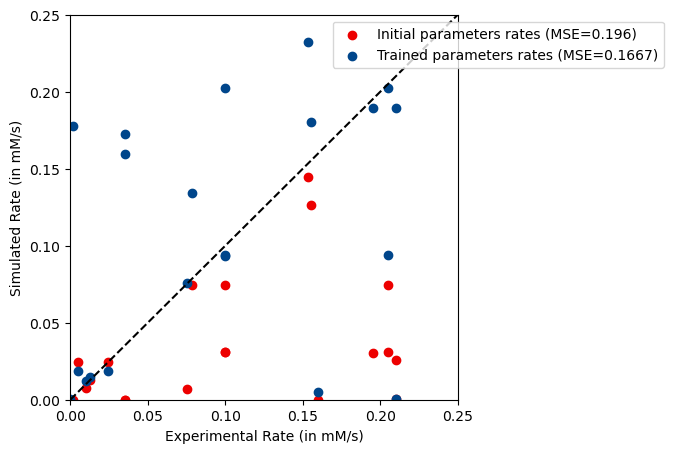

In [263]:
fig,ax=plt.subplots(figsize=(5,5))
ax.scatter(steady_state['ss_canelas'],steady_state['ss_glucose_pulse_initial'],label="Initial parameters rates (MSE=0.196)",c="#ED0000FF")
ax.scatter(steady_state['ss_canelas'],steady_state['ss_glucose_pulse_parameterized'],label="Trained parameters rates (MSE=0.1667)",c="#00468BFF")
ax.set_xlim(0,0.25)
ax.set_ylim(0,0.25)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--",c="black")
ax.set_xlabel("Experimental Rate (in mM/s)")
ax.set_ylabel("Simulated Rate (in mM/s)")
ax.legend(loc="upper right",bbox_to_anchor=(1.55,1))

np.mean(np.sum((steady_state['ss_canelas']-steady_state['ss_glucose_pulse_parameterized'])**2))

# np.mean(np.sum((steady_state['ss_canelas']-steady_state['ss_glucose_pulse_initial'])**2))
